# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from prettytable import PrettyTable

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(os.getcwd()+'/Assignment/database.sqlite')

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 70000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
filtered_data['Score'] = filtered_data["Score"].map(partition)
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (70000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(62864, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

89.80571428571429

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible. Hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(62862, 10)


1    52600
0    10262
Name: Score, dtype: int64

## [2.4] Upsampling the data for a balanced dataset

In [10]:
# final_neg = final[final.Score==0]
# final_neg_upsampled = resample(final_neg, replace=True, n_samples=38000, random_state=1)

In [11]:
# final = pd.concat([final[final.Score==1], final_neg_upsampled])
# final.shape

## [2.5] Sorting the data according to Time

In [12]:
final = final.sort_values(by="Time", ascending=True).reset_index(drop=True)

In [13]:
#Verifying the data
final.head(5)

Id   ProductId          UserId      ProfileName  HelpfulnessNumerator  \
0   1245  B00002Z754  A29Z5PI9BW2PU3           Robbie                     7   
1   1244  B00002Z754  A3B8RCEI0FXFI6        B G Chase                    10   
2  30629  B00008RCMI  A19E94CF5O1LY7    Andrew Arnold                     0   
3  30630  B00008RCMI  A284C7M23F0APC       A. Mendoza                     0   
4  66610  B0000SY9U4  A3EEDHNHI4WNSH  Joanna J. Young                    23   

   HelpfulnessDenominator  Score        Time  \
0                       7      1   961718400   
1                      10      1   962236800   
2                       0      1  1067040000   
3                       0      1  1067040000   
4                      23      1  1067472000   

                                      Summary  \
0                               Great Product   
1              WOW Make your own 'slickers' !   
2  I've chewed this gum many times, but used?   
3                    Best sugarless gum ever!   
4                                       Yummy   

                                                Text  
0  This was a really good idea and the final prod...  
1  I just received my shipment and could hardly w...  
2  Nothing against the product, but it does bothe...  
3  I love this stuff. It is sugar-free so it does...  
4  If you've never tried Kona coffee, Aloha Islan...

In [14]:
final.tail(5)

Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
62857  47562  B004M0Y8T8  A2QJS6MHTIFSRI     Georgie                     0   
62858  20930  B001L1MKLY  A38XYFHXEUNUW6   bleaufire                     0   
62859  32932  B001P05K8Q  A3L0B5NBTQ7ZHO       Julie                     0   
62860   7178  B004OQLIHK   AKHQMSUORSA91    Pen Name                     0   
62861   5703  B009WSNWC4   AMP7K1O84DH1T        ESTY                     0   

       HelpfulnessDenominator  Score        Time  \
62857                       0      1  1351209600   
62858                       0      1  1351209600   
62859                       0      1  1351209600   
62860                       0      1  1351209600   
62861                       0      1  1351209600   

                            Summary  \
62857         Sleeping a lot better   
62858                Yummy & Subtle   
62859  Great results but they stink   
62860                    Delicious!   
62861                     DELICIOUS   

                                                    Text  
62857  Hubby and I (both 63) have been drinking about...  
62858  Just made my first pot of this wonderful coffe...  
62859  We originally purchased these chews from our v...  
62860  I have ordered these raisins multiple times.  ...  
62861  Purchased this product at a local store in NY ...

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
from bs4 import BeautifulSoup

def cleanhtml(dirtytext):
    return BeautifulSoup(dirtytext, "html.parser").get_text()

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
#Storing the stopwords of english
stopwords = set(nltk.corpus.stopwords.words("english"))
# stopwords

In [18]:
#function to remove stopwords, removing alphaneumeric words and lowering caps
def secondClean(text):
    filtered_words = []
    text = re.sub('[^A-Za-z]+', ' ', text)
    for x in text.split():
        if x not in stopwords and x.isalpha():
            filtered_words.append(x.lower())
    return " ".join(filtered_words).strip()

In [19]:
#Testing function:
x = cleanhtml("<div><a>XYZZYSPOON!</a></div>")
print(x)
print(secondClean("[Auld] [Lang Syne"))

XYZZYSPOON!
auld lang syne


In [20]:
#Preprocessing the reviews
final["CleanedText"] = final["Text"].apply(lambda x:cleanhtml(x))
final["CleanedText"] = final["CleanedText"].apply(lambda x: decontracted(x))
final["CleanedText"] = final["CleanedText"].apply(lambda x: secondClean(x))

In [21]:
final["CleanedText"].values[0]

'this really good idea final product outstanding i use decals car window everybody asks bought decals made two thumbs'

In [22]:
final["Text"].values[0]

'This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!'

# [4] Applying Kmeans

### General functions for smooth sailing

In [23]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [54]:
def plot_word_cloud(topn_class, n, i):
    w_cloud = " ".join([x for x in topn_class][:20])
    stopwords = set(STOPWORDS) 
    wordcloud = WordCloud(width = 700, height = 500, background_color ='black', stopwords = STOPWORDS).generate(w_cloud) 

    # plot the WordCloud image                        
    plt.figure(figsize = (7, 5)) 
    plt.imshow(wordcloud, interpolation = 'bilinear') 
    plt.axis("off") 
    plt.title(f"Top {n} most important features of cluster {i}")
    plt.tight_layout(pad = 0) 
    plt.show()

In [53]:
from wordcloud import WordCloud, STOPWORDS
def imp_features(clf, feature_names=0, bow_tf_flag=False, n=20, df_temp=0):
    
    if bow_tf_flag==True:
        coef = clf.cluster_centers_
        #Putting the features in a df
        coef_df = pd.DataFrame(coef, columns = feature_names)
        #Fetching the number of figures to print
        num_fig = len(coef_df)
        for i in range(num_fig):
            wordcloud = WordCloud(width = 700, height = 500, background_color ='black', stopwords = stopwords).generate_from_frequencies(coef_df.iloc[i,:].sort_values(ascending = False)[0:20])
                # plot the WordCloud image                        
            plt.figure(figsize = (7, 5)) 
            plt.imshow(wordcloud, interpolation = 'bilinear') 
            plt.axis("off") 
            plt.title(f"Top {n} most important features of cluster {i}")
            plt.tight_layout(pad = 0) 
            plt.show()
    else:
        df_temp["label"] = clf.labels_
        for i in range(len(set(clf.labels_)) - 1):
            text = []
            words_per_cluster = df_temp.groupby(["label"]).groups[i]
            for j in range(len(words_per_cluster)):
                text.append(df_temp.loc[words_per_cluster[j]]["CleanedText"])
            plot_word_cloud(text, n, i)
    
    return print("-"*30)

        

In [26]:
def plot_the_plot(clf_score):
    sns.lineplot([x[0] for x in clf_score], [x[1] for x in clf_score], \
             color ="blue")
    sns.scatterplot([x[0] for x in clf_score], [x[1] for x in clf_score], \
                 color ="red")
    
    plt.xlabel(f"K")
    plt.ylabel("Inertia")
    plt.title("Intertia vs K")

    plt.show()

In [45]:
def get_best_hyperparam(X):
    clf_score = []
    
    iterator = np.arange(1,10)
    for hyper in tqdm(iterator):
        clf = KMeans(n_clusters=hyper)
        clf.fit(X)
        clf_score.append([hyper, clf.inertia_])
        
    return plot_the_plot(clf_score)

In [29]:
from sklearn.preprocessing import StandardScaler


X_kmeans = final["CleanedText"].values[:50000]
X_others = final["CleanedText"].values[:5000]
df_temp_kmeans = final.iloc[:50000, :]
df_temp_others = final.iloc[:5000, :]

## [4.1] Applying Kmeans with BOW

In [29]:
#Creating a bow instance
bow = CountVectorizer(ngram_range=(1,2))
X_bow = bow.fit_transform(X_kmeans)
X_bow = StandardScaler(with_mean=False).fit_transform(X_bow)

/home/ae/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ae/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100%|██████████| 14/14 [18:47<00:00, 95.18s/it]


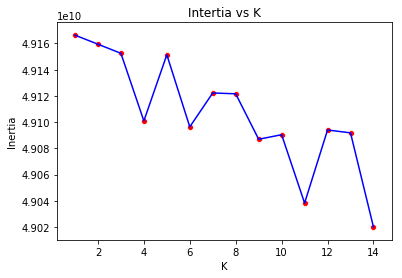

In [30]:
get_best_hyperparam(X_bow)

### Visualization of clusters

In [31]:
clf = KMeans(n_clusters = 4)
clf.fit(X_bow)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

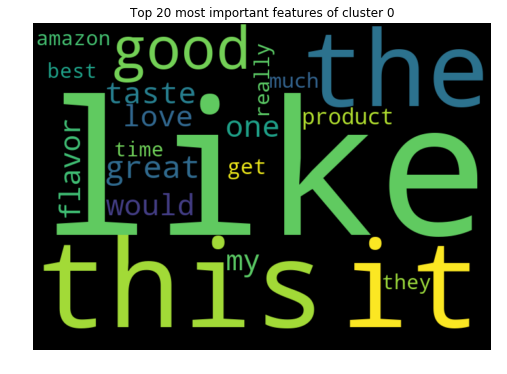

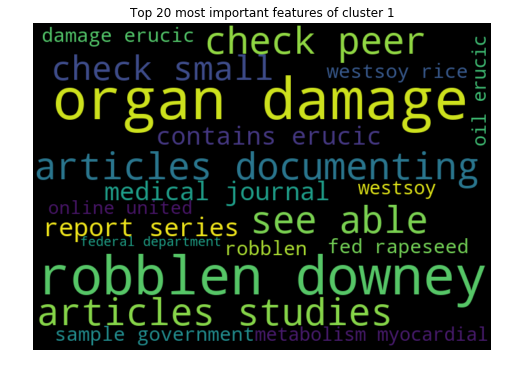

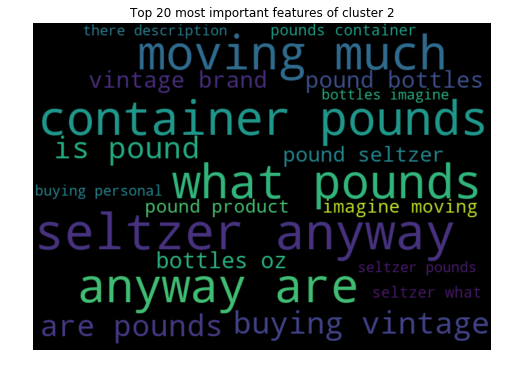

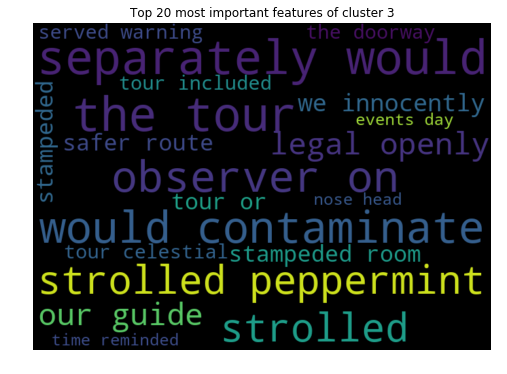

------------------------------


In [41]:
imp_features(bow.get_feature_names(), clf, bow_tf_flag=True, n=20)

### Observation:

- Cluster 0 represents positive tokens
- Rest of the clusters have noise

## [4.2] Applying Kmeans with tf-idf

In [34]:
tf_idf = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_tfidf = tf_idf.fit_transform(X_kmeans)
X_tfidf = StandardScaler(with_mean=False).fit_transform(X_tfidf)

100%|██████████| 14/14 [41:59<00:00, 208.47s/it]


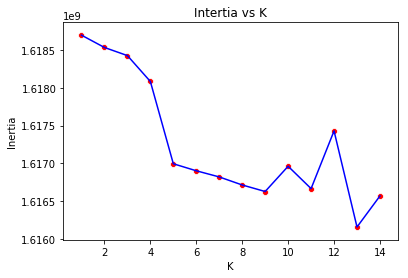

In [43]:
get_best_hyperparam(X_tfidf)

### Visualization of clusters

In [44]:
clf = KMeans(n_clusters = 5)
clf.fit(X_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

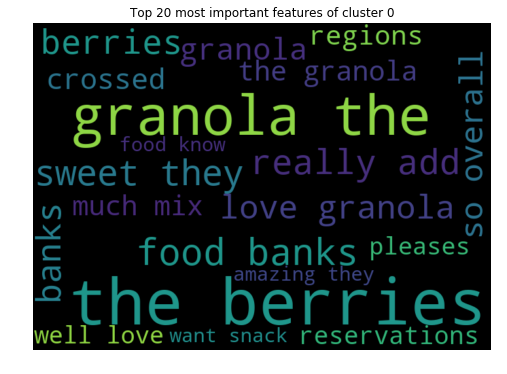

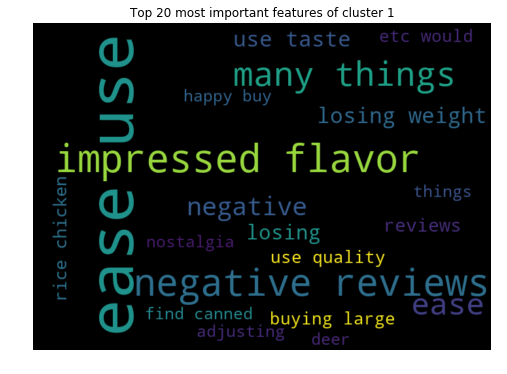

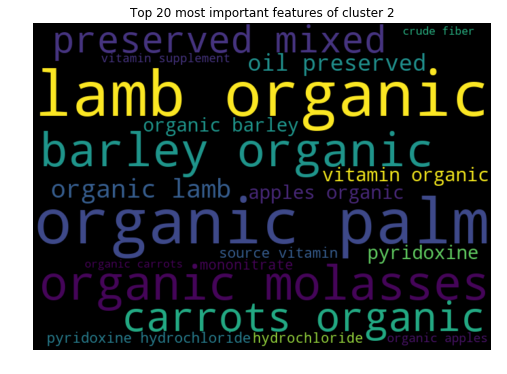

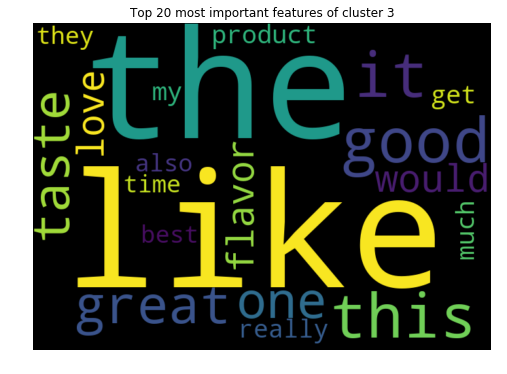

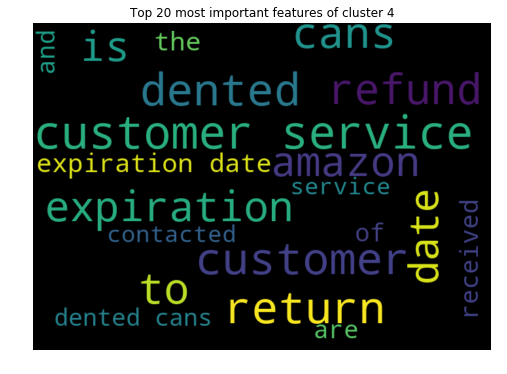

------------------------------


In [46]:
imp_features(tf_idf.get_feature_names(), clf, bow_tf_flag=True, n=20)

### Observations:

- Cluster 3 represents affinity tokens for positive reviews
- Cluster 4 however sums up the quality of service

## [4.3] Applying Kmeans with avg_w2v

In [32]:
def compute_avgw2v(list_of_reviews, w2v_model):
    w2v_words = list(w2v_model.wv.vocab)
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_reviews): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [48]:
# Train your own Word2Vec model using your own text corpus for train data
i=0
list_of_reviews_train=[]
for review in X_kmeans:
    list_of_reviews_train.append(review.split())

w2v_model=Word2Vec(list_of_reviews_train,min_count=5,size=50, workers=4)

X_aw2v = compute_avgw2v(list_of_reviews_train, w2v_model)

100%|██████████| 50000/50000 [01:11<00:00, 699.92it/s]

50000
50


In [50]:
X_aw2v =StandardScaler(with_mean=False).fit_transform(X_aw2v)

100%|██████████| 9/9 [00:30<00:00,  4.52s/it]


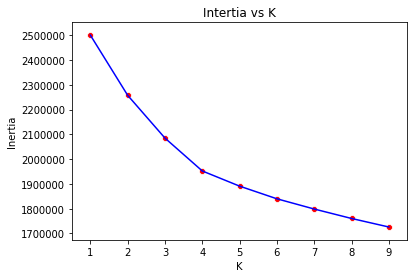

In [51]:
get_best_hyperparam(X_aw2v)

### Visualization of clusters

In [52]:
clf = KMeans(n_clusters = 4)
clf.fit(X_aw2v)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

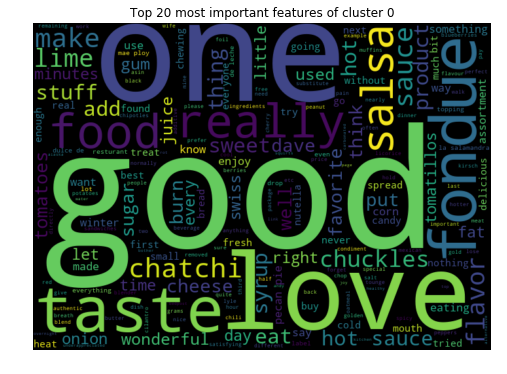

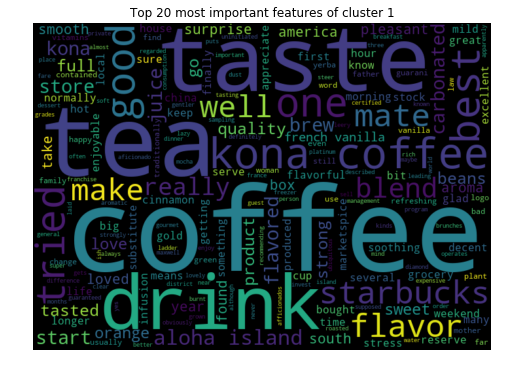

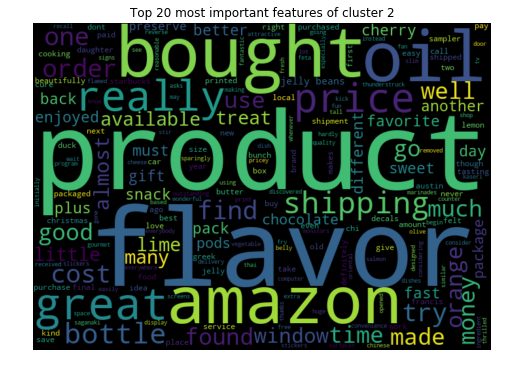

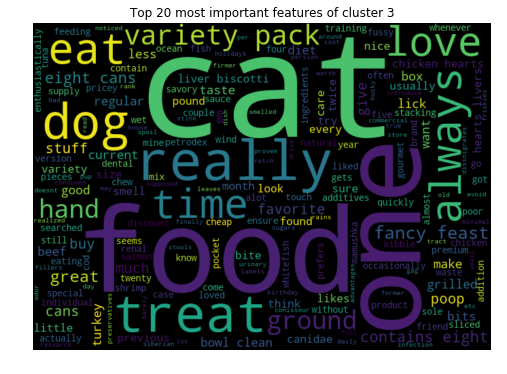

------------------------------


In [77]:
imp_features(clf, feature_names=0, bow_tf_flag=False, n=20, df_temp=df_temp_kmeans)

### Observations:

- Clusters have noticeable noises but the cluster 2 shows some tokens related to the products and service

## [4.4] Applying Kmeans on tfidf_w2v

In [33]:
def compute_tfidf_w2v(model, w2v_model, list_of_reviews):
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    w2v_words = list(w2v_model.wv.vocab)
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_reviews): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [79]:
X_tfidfw2v = compute_tfidf_w2v(tf_idf, w2v_model, list_of_reviews_train)

100%|██████████| 50000/50000 [19:21<00:00, 43.03it/s] 


In [81]:
X_tfidfw2v =StandardScaler(with_mean=False).fit_transform(X_tfidfw2v)

100%|██████████| 9/9 [00:30<00:00,  4.43s/it]


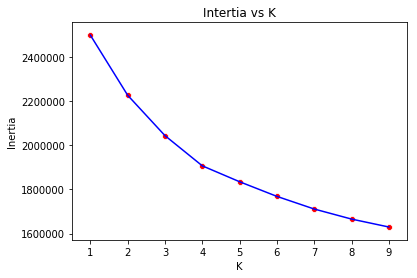

In [82]:
get_best_hyperparam(X_tfidfw2v)

### Visualization of clusters

In [83]:
clf = KMeans(n_clusters = 4)
clf.fit(X_tfidfw2v)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

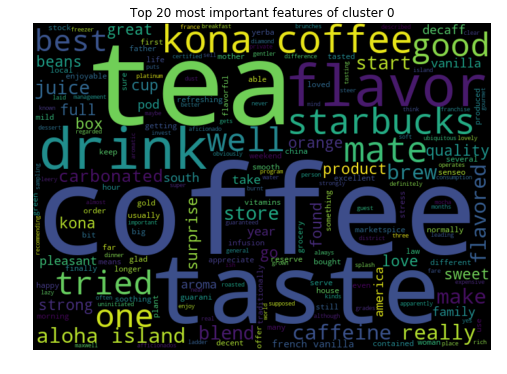

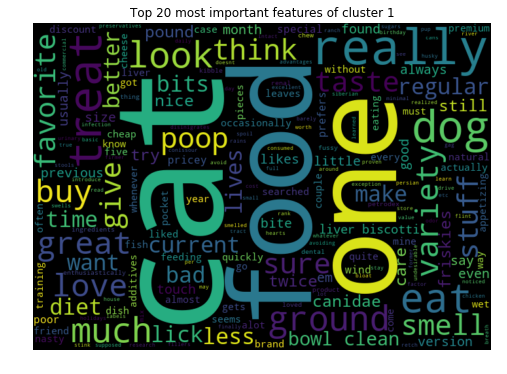

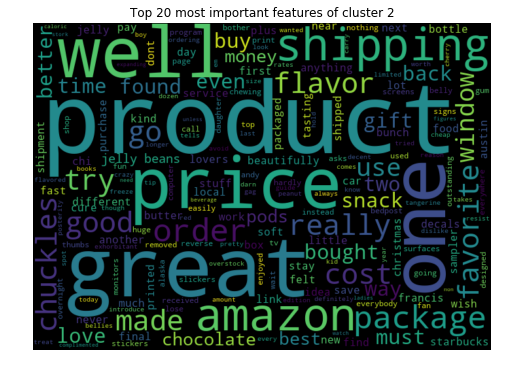

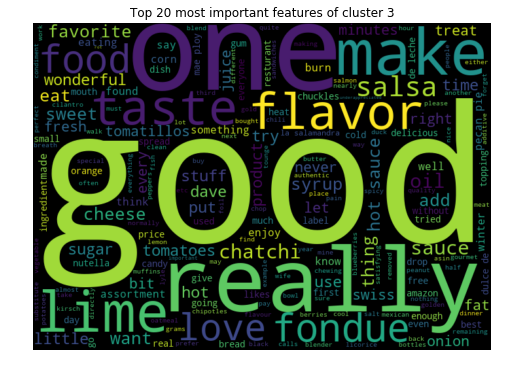

------------------------------


In [84]:
imp_features(clf, feature_names=0, bow_tf_flag=False, n=20, df_temp=df_temp_kmeans)

### Observations:

- Cluster 1 represents the quality of products and service
- Cluster 2 and 3 represents the positive tokens for reviews

# [5] Applying Agglomerative Clustering

### General functions for smooth sailing

In [27]:
df_temp_others = final.iloc[:5000, :]

In [30]:
tf_idf = TfidfVectorizer(min_df=10)
X_tfidf = tf_idf.fit_transform(X_others)
X_tfidf = StandardScaler(with_mean=False).fit_transform(X_tfidf)

## [5.1] Applying Agglomerative Clustering with Avg_w2v

In [35]:
# Train your own Word2Vec model using your own text corpus for train data
i=0
list_of_reviews_train=[]
for review in X_others:
    list_of_reviews_train.append(review.split())

w2v_model=Word2Vec(list_of_reviews_train,min_count=5,size=50, workers=4)

X_aw2v = compute_avgw2v(list_of_reviews_train, w2v_model)

100%|██████████| 5000/5000 [00:03<00:00, 1315.51it/s]

5000
50


In [36]:
X_aw2v =StandardScaler(with_mean=False).fit_transform(X_aw2v)

In [96]:
clf = AgglomerativeClustering(n_clusters=2).fit(X_aw2v)

### Visualization of clusters

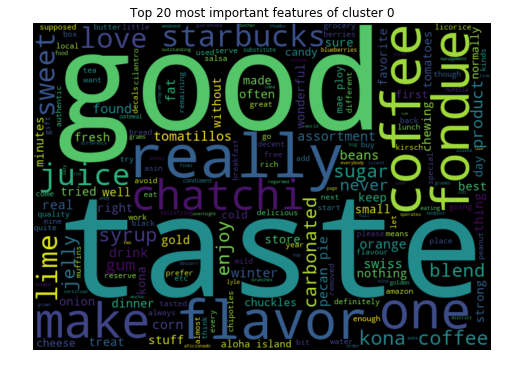

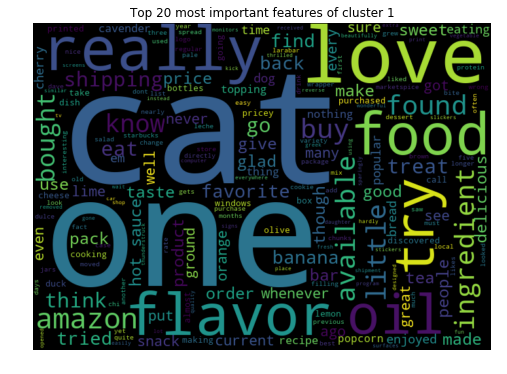

------------------------------


In [97]:
imp_features(clf, feature_names=0, bow_tf_flag=False, n=20, df_temp=df_temp_others)

### Observations:

- Cluster 0 represents the nature of reviews, mostly positive
- Cluster 1 has much noise

In [98]:
clf = AgglomerativeClustering(n_clusters=5).fit(X_aw2v)

### Visualization of clusters

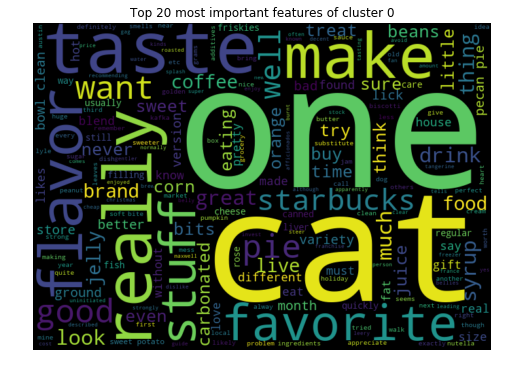

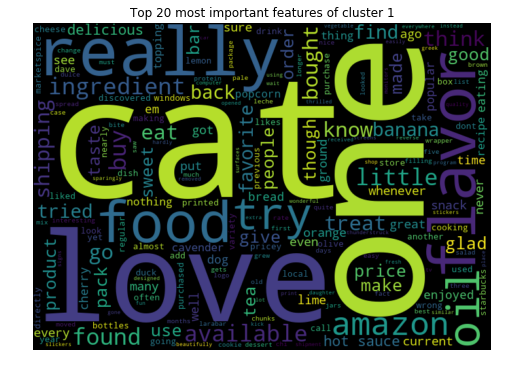

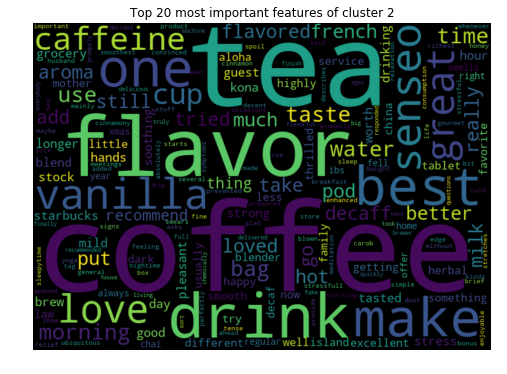

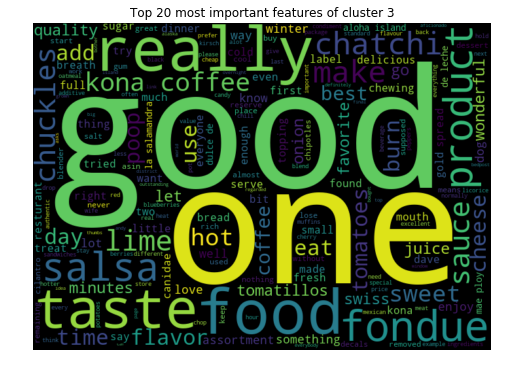

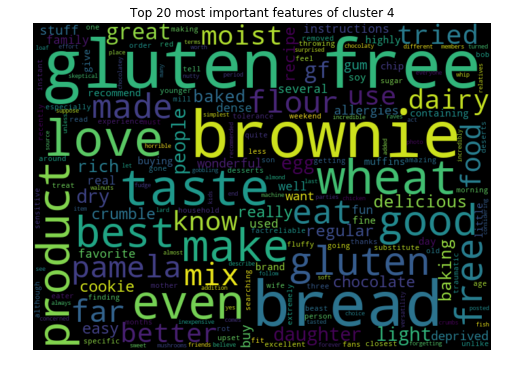

------------------------------


In [99]:
imp_features(clf, feature_names=0, bow_tf_flag=False, n=20, df_temp=df_temp_others)

### Observations:

- Cluster 0 represents the nature of products
- Cluster 3 represents the quality of products
- Cluster 4 represents description of products

## [5.2] Applying Agglomerative Clustering with TFIDF_w2v

In [37]:
X_tfidfw2v = compute_tfidf_w2v(tf_idf, w2v_model, list_of_reviews_train)

100%|██████████| 5000/5000 [01:26<00:00, 57.62it/s]


In [38]:
X_tfidfw2v =StandardScaler(with_mean=False).fit_transform(X_tfidfw2v)

In [103]:
clf = AgglomerativeClustering(n_clusters=2).fit(X_tfidfw2v)

### Visualization of clusters

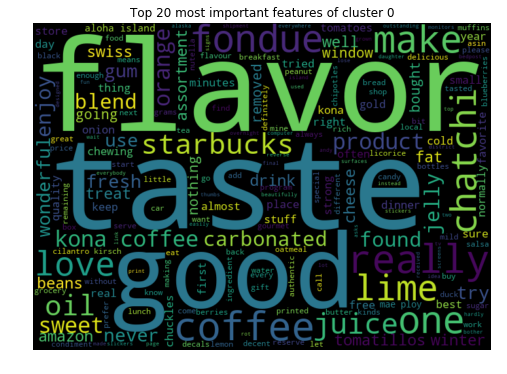

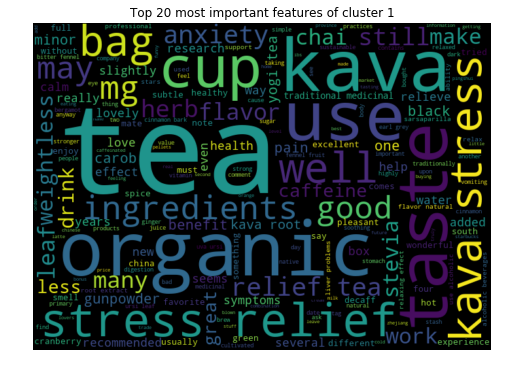

------------------------------


In [104]:
imp_features(clf, feature_names=0, bow_tf_flag=False, n=20, df_temp=df_temp_others)

### Observations:

- Cluster 0 represents the nature of reviews, mostly positive
- Cluster 1 has much noise

In [105]:
clf = AgglomerativeClustering(n_clusters=5).fit(X_tfidfw2v)

### Visualization of clusters

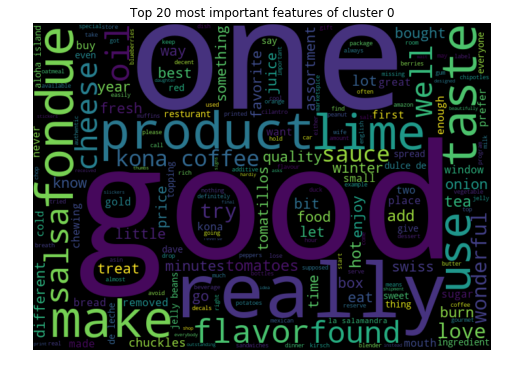

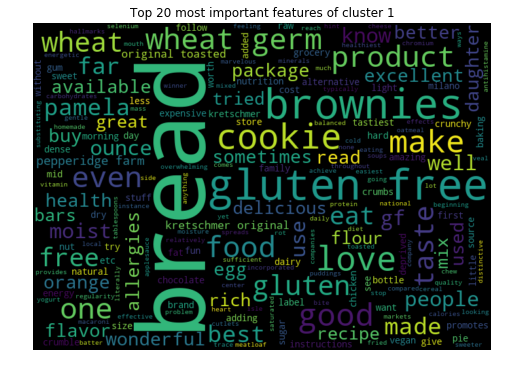

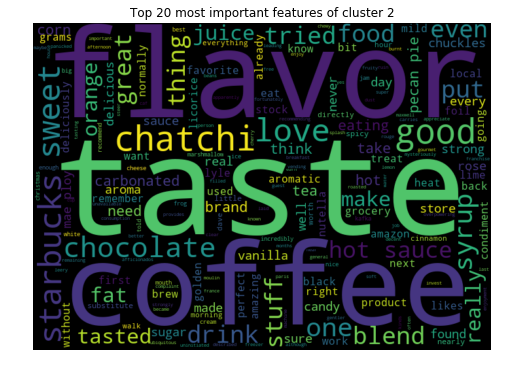

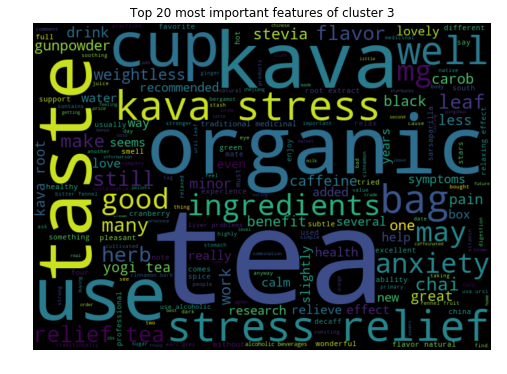

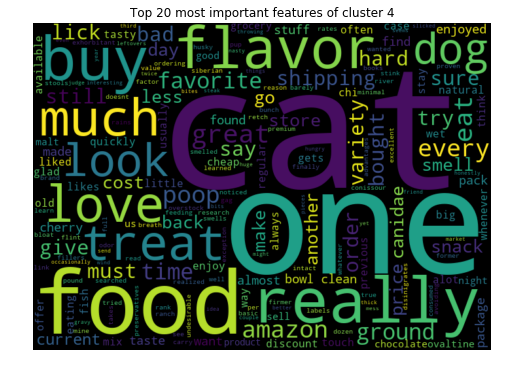

------------------------------


In [106]:
imp_features(clf, feature_names=0, bow_tf_flag=False, n=20, df_temp=df_temp_others)

### Observations:

- Cluster 0 represents the quality of products
- Cluster 1 represents the type of products
- Cluster 2 represents description of products

# [6] Applying DBSCAN Clustering

### General functions for smooth sailing

In [26]:
from sklearn.neighbors import NearestNeighbors

In [49]:
def opt_dbscan(X):
    min_points = 50
    k_v = {}
    neigh = NearestNeighbors(n_neighbors = min_points, metric = "euclidean")
    neigh.fit(X)
    #Fetching the distance
    dist = np.array(neigh.kneighbors(n_neighbors = min_points, return_distance = True))
#     print(dist)
    for dt, idx in zip(dist[0], dist[1]):
        k_v[idx[-1]] = dt[-1]
    sorted_dist = sorted((value,key) for (key, value) in k_v.items())
    distance = []
    index = []
    for d, i in sorted_dist:
        distance.append(d)
        index.append(i)
    plt.plot(distance, sorted(index, reverse=True))
    plt.title("Index vs Distance")
    plt.xlabel("Index of each data-points")
    plt.ylabel("Distance")
    plt.show()

## [5.1] Applying DBSCAN with Avg_w2v

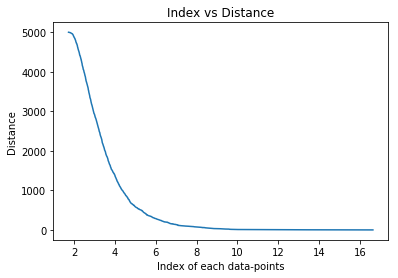

In [50]:
opt_dbscan(X_aw2v)

In [56]:
clf = DBSCAN(eps=6).fit(X_aw2v)

### Visualization of clusters

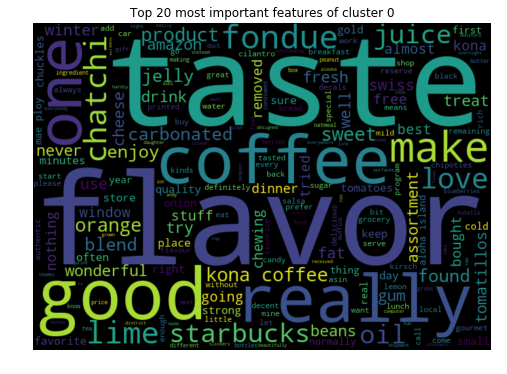

------------------------------


In [57]:
imp_features(clf, feature_names=0, bow_tf_flag=False, n=20, df_temp=df_temp_others)

### Observations:
- The cluster is filled with noise

## [5.2] Applying DBSCAN with TFIDF_w2v

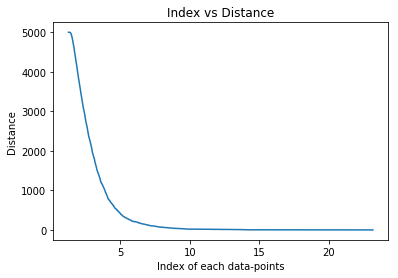

In [58]:
opt_dbscan(X_tfidfw2v)

In [59]:
clf = DBSCAN(eps=7).fit(X_tfidfw2v)

### Visualization of clusters

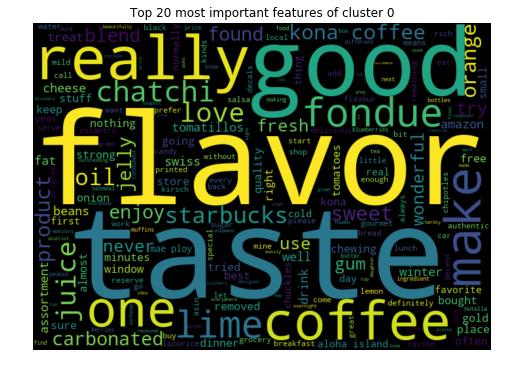

------------------------------


In [60]:
imp_features(clf, feature_names=0, bow_tf_flag=False, n=20, df_temp=df_temp_others)

### Observations:
- Cluster 0 compliments the type of products and the quality of such

# Conclusion

In [61]:
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Clusters"]
x.add_row(["BOW", "Kmeans", 4])
x.add_row(["TFIDF", "Kmeans", 5])
x.add_row(["Avg_w2v", "Kmeans", 4])
x.add_row(["TFIDF_w2v", "Kmeans", 4])


x.add_row(["Avg_w2v", "Agglomerative", "2,5"])
x.add_row(["TFIDF_w2v","Agglomerative", "2,5"])

x.add_row(["Avg_w2v", "DBSCAN", 1])
x.add_row(["TFIDF_w2v","DBSCAN", 1])
print(x)


+------------+---------------+----------+
| Vectorizer |     Model     | Clusters |
+------------+---------------+----------+
|    BOW     |     Kmeans    |    4     |
|   TFIDF    |     Kmeans    |    5     |
|  Avg_w2v   |     Kmeans    |    4     |
| TFIDF_w2v  |     Kmeans    |    4     |
|  Avg_w2v   | Agglomerative |   2,5    |
| TFIDF_w2v  | Agglomerative |   2,5    |
|  Avg_w2v   |     DBSCAN    |    1     |
| TFIDF_w2v  |     DBSCAN    |    1     |
+------------+---------------+----------+
